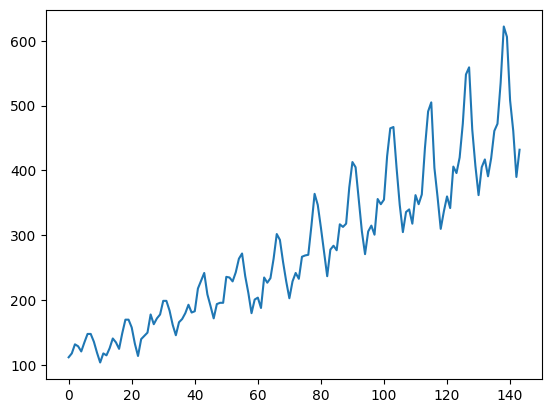

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

In [8]:

train_size = int(len(timeseries) * 0.75)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [9]:
import torch

def create_dataset(dataset, lookback):

    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [10]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([107, 1, 1]) torch.Size([107, 1, 1])
torch.Size([35, 1, 1]) torch.Size([35, 1, 1])


In [11]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [16]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 246.7112, test RMSE 437.6881
Epoch 100: train RMSE 200.7044, test RMSE 388.8090
Epoch 200: train RMSE 164.8234, test RMSE 349.1534
Epoch 300: train RMSE 134.2541, test RMSE 312.9511
Epoch 400: train RMSE 109.8163, test RMSE 280.2011
Epoch 500: train RMSE 89.0000, test RMSE 249.2745
Epoch 600: train RMSE 71.2149, test RMSE 220.1793
Epoch 700: train RMSE 57.7330, test RMSE 193.9750
Epoch 800: train RMSE 47.1738, test RMSE 170.7417
Epoch 900: train RMSE 40.0615, test RMSE 150.7398
Epoch 1000: train RMSE 38.9427, test RMSE 137.2175
Epoch 1100: train RMSE 34.6053, test RMSE 122.1863
Epoch 1200: train RMSE 30.6119, test RMSE 110.5123
Epoch 1300: train RMSE 29.3401, test RMSE 103.5117
Epoch 1400: train RMSE 27.5262, test RMSE 97.7167
Epoch 1500: train RMSE 28.4559, test RMSE 92.6011
Epoch 1600: train RMSE 28.0990, test RMSE 91.4266
Epoch 1700: train RMSE 26.3631, test RMSE 87.4122
Epoch 1800: train RMSE 26.5345, test RMSE 90.3603
Epoch 1900: train RMSE 26.3282, test RMSE 8

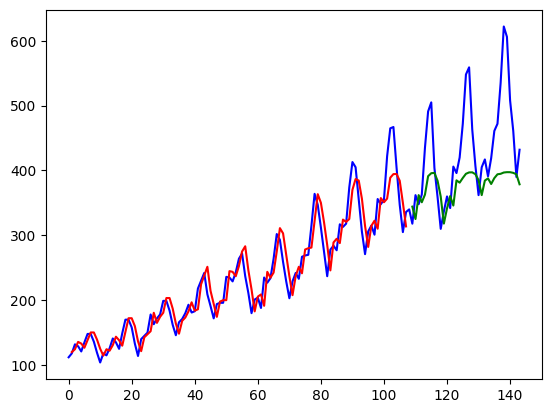

In [17]:
with torch.no_grad():

    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]

    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()